In [ ]:
import sys
import os

file_path = '/kaggle/input/specformer/'
sys.path.append(file_path)

data_root_dir = os.path.join(file_path, "processed/")

In [ ]:
import torch
torch.multiprocessing.set_start_method('spawn', force=True)
from spectrum_dataset import SpectrumDataset, collate_fn
from spectrum_model import SpectrumModel
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch import Tensor

import matplotlib.pyplot as plt

In [ ]:
max_seq_len = 20
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [ ]:
dataset = SpectrumDataset(root_dir=data_root_dir)
print(len(dataset))

processing:  <_io.TextIOWrapper name='processed/IARPA3_best_tissue_processed' mode='r' encoding='UTF-8'>
6842
(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0.]]), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 363510.0, 0, 49102.0, 0, 0,

In [5]:
count = 0
for i in range(len(dataset)):
    if not dataset[i][1]:
        count += 1

print(count)

0


In [ ]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)

In [7]:
def cosine_loss(output, target):
    return 1 - F.cosine_similarity(output, target, dim=1).mean()

class CosineLoss(nn.Module):
    __constants__ = ['dim', 'eps']
    dim: int
    eps: float

    def __init__(self, dim: int = 1, eps: float = 1e-8) -> None:
        super().__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x1: Tensor, x2: Tensor) -> Tensor:
        x1_sqrt = x1.sqrt()
        x2_sqrt = x2.sqrt()
        return (1 - F.cosine_similarity(x1, x2, self.dim, self.eps)).mean()

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for sequences, labels, charges, NCEs in dataloader:
        sequences = sequences.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        charges = charges.to(device, non_blocking=True)
        NCEs = NCEs.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(sequences, charges, NCEs)
        #print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for sequences, labels, charges, NCEs in dataloader:
            sequences = sequences.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            charges = charges.to(device, non_blocking=True)
            NCEs = NCEs.to(device, non_blocking=True)
            
            outputs = model(sequences, charges, NCEs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
epochs = 2000

model = SpectrumModel(token_size=dataset.token_dim, dict_size=dataset.ionDictN, seq_max_len=max_seq_len).to(device)
#opt = optim.AdamW(model.parameters(), lr=2e-2, weight_decay=1e-3)
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
crit = CosineLoss(dim=1)

patience = 5
training_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_no_improvement = 0
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, opt, crit)
    val_loss = evaluate(model, val_loader, crit)

    training_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improvement = 0
        torch.save(model.state_dict(), "best_model_test.pth")
        print("Saved best model")
    else:
        epochs_no_improvement += 1

    if epochs_no_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1} with no improvement for {epochs_no_improvement} epochs.")
        break
    

Epoch 1/2000, Train Loss: 0.9152, Val Loss: 0.8690
Saved best model
Epoch 2/2000, Train Loss: 0.7953, Val Loss: 0.7089
Saved best model
Epoch 3/2000, Train Loss: 0.6355, Val Loss: 0.5634
Saved best model
Epoch 4/2000, Train Loss: 0.5201, Val Loss: 0.4845
Saved best model
Epoch 5/2000, Train Loss: 0.4725, Val Loss: 0.4586
Saved best model
Epoch 6/2000, Train Loss: 0.4543, Val Loss: 0.4472
Saved best model
Epoch 7/2000, Train Loss: 0.4463, Val Loss: 0.4415
Saved best model
Epoch 8/2000, Train Loss: 0.4434, Val Loss: 0.4403
Saved best model
Epoch 9/2000, Train Loss: 0.4426, Val Loss: 0.4395
Saved best model
Epoch 10/2000, Train Loss: 0.4412, Val Loss: 0.4377
Saved best model
Epoch 11/2000, Train Loss: 0.4399, Val Loss: 0.4362
Saved best model
Epoch 12/2000, Train Loss: 0.4386, Val Loss: 0.4354
Saved best model
Epoch 13/2000, Train Loss: 0.4385, Val Loss: 0.4355
Epoch 14/2000, Train Loss: 0.4385, Val Loss: 0.4355
Epoch 15/2000, Train Loss: 0.4381, Val Loss: 0.4353
Saved best model
Epoch 16

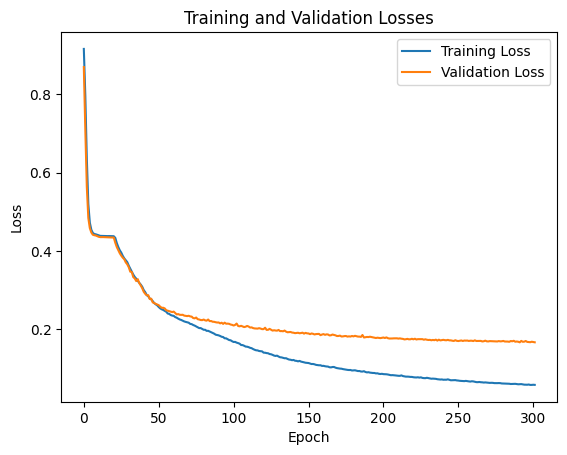

In [11]:
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [9]:
weight_decay_values = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

for wd in weight_decay_values:
    model = SpectrumModel(token_size=dataset.token_dim, dict_size=dataset.ionDictN, seq_max_len=max_seq_len)
    opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=wd)
    crit = CosineLoss(dim=1)

    for epoch in range(20):
        train_loss = train_epoch(model, train_loader, opt, crit)
        print(f"Epoch {epoch + 1}/{20}, Train Loss: {train_loss:.4f}")

    val_loss = evaluate(model, val_loader, crit)
    print(f"Validation Loss with weight decay {wd}: {val_loss:.4f}")

Epoch 1/20, Train Loss: 0.9165
Epoch 2/20, Train Loss: 0.7967
Epoch 3/20, Train Loss: 0.6387
Epoch 4/20, Train Loss: 0.5253
Epoch 5/20, Train Loss: 0.4757
Epoch 6/20, Train Loss: 0.4571
Epoch 7/20, Train Loss: 0.4482
Epoch 8/20, Train Loss: 0.4435
Epoch 9/20, Train Loss: 0.4421
Epoch 10/20, Train Loss: 0.4405
Epoch 11/20, Train Loss: 0.4397
Epoch 12/20, Train Loss: 0.4386
Epoch 13/20, Train Loss: 0.4385
Epoch 14/20, Train Loss: 0.4382
Epoch 15/20, Train Loss: 0.4383
Epoch 16/20, Train Loss: 0.4381
Epoch 17/20, Train Loss: 0.4379
Epoch 18/20, Train Loss: 0.4381
Epoch 19/20, Train Loss: 0.4380
Epoch 20/20, Train Loss: 0.4380
Validation Loss with weight decay 1e-07: 0.4348
Epoch 1/20, Train Loss: 0.9163
Epoch 2/20, Train Loss: 0.7953
Epoch 3/20, Train Loss: 0.6346
Epoch 4/20, Train Loss: 0.5193
Epoch 5/20, Train Loss: 0.4718
Epoch 6/20, Train Loss: 0.4536
Epoch 7/20, Train Loss: 0.4468
Epoch 8/20, Train Loss: 0.4436
Epoch 9/20, Train Loss: 0.4424
Epoch 10/20, Train Loss: 0.4409
Epoch 11/2

In [8]:
# find learning rate

model = SpectrumModel(token_size=dataset.token_dim, dict_size=dataset.ionDictN, seq_max_len=max_seq_len)
#opt = optim.AdamW(model.parameters(), lr=2e-2, weight_decay=1e-3)
opt = optim.AdamW(model.parameters(), lr=1e-7)
crit = CosineLoss(dim=1)

from lr_finder import LRFinder

lr_finder = LRFinder(model, opt, crit)

lr_finder.range_test(train_loader, end_lr=.1, num_iter=1000)


/Users/ju5tinz/Dev/spectrum-project/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
100%|██████████| 1000/1000 [11:05<00:00,  1.50it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 9.53E-05


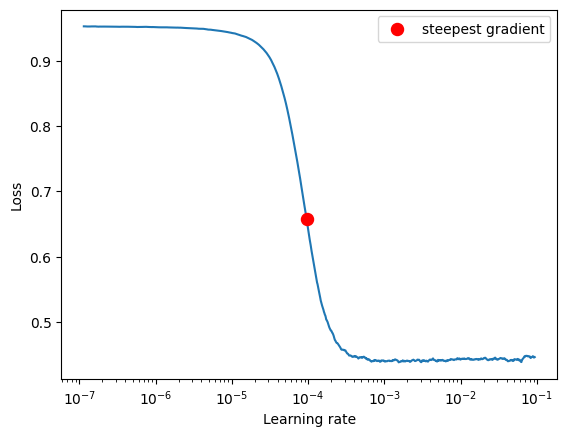

In [9]:
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()  # to reset the model and optimizer to their initial state